# Report
## map 1
將i->j變成(i,j)的key value pair，產生以inlink和outlink的兩個方式顯示，以方便判斷至少幾個Node
#### format : (i,j)、(i,k)、(j,m)...
## reduce 1
將兩個RDD 都 groupByKey以得知此Node指向哪幾個Node，以及哪幾個Node指向此Node
#### format : (i,(j,k))、(j,(m,))...
## compute Node
以全部的node的最大值為"至少"有幾個Node
## map 2
產生初始 rank 的 key value pair
#### format : (i,1.0/Node)、(j,1.0/Node)...
## reduce 2
將初始rank與map 1 產生的outlink key value pair合併
#### format : (i,((j,k),1.0/Node))、(j,((m,),1.0/Node))...
## map 3
將一node i的rank均分給它所指到的node，若node i未指到任何node則給的值為0
#### format : (j,beta*ri/di) where ri是node i的old rank，di是node i的outlink數，beta=0.8、(n,0)...
## reduce 3
用reduceByKey計算出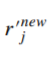
#### format : (i,ri')、(j,rj')...
## compute S
計算 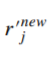的sum
## map 4
產生 (1-S)/Node 的 key pair value
#### format : (i,(1-S)/Node)、(j,(1-S)/Node)...
## reduce 4
與reduce 3的結果合併再將它們加起來產生新rank
#### format : (i,(ri',(1-S)/Node))、(j,(rj',(1-S)/Node))... => (i,ri)、(j,rj)... where ri = ri'+ (1-S)/Node
### 接著回到 reduce 2 共做 20 個iterations，做完後根據rank的值做排序再output到file

In [1]:
from pyspark import SparkConf, SparkContext
from operator import add

In [2]:
sc.stop()

In [3]:
conf = SparkConf().setMaster("local").setAppName("HW2")
sc = SparkContext(conf=conf)
lines = sc.textFile("input.txt")

In [4]:
def mapper1(line):
    tmp = line.split("\t")
    edgelist = []
    edgelist.append((int(tmp[0]),int(tmp[1])))
    return edgelist
def mapper2(line):
    tmp = line.split("\t")
    edgelist = []
    edgelist.append((int(tmp[1]),int(tmp[0])))
    return edgelist   

In [5]:
# map 1 & reduce 1
edge_outlink = lines.flatMap(mapper1).groupByKey().mapValues(tuple)
edge_inlink = lines.flatMap(mapper2).groupByKey().mapValues(tuple)

In [6]:
#compute Node
Node = max(int(edge_outlink.max()[0]),int(edge_inlink.max()[0]))
Node

10878

In [7]:
beta = 0.8
iteration = 20

In [8]:
# map 2
rank = sc.parallelize(range(1,Node+1)).map(lambda x: (x,1.0/Node))

In [9]:
def mapper3(line):
    l = []
    for i in range(1,Node+1):
        if i in line[1][0]:
            l.append((i,beta*line[1][1]/len(line[1][0])))
        else:
            l.append((i,0))
    return l;

In [10]:
for i in range(iteration):
    # reduce 2
    com = edge_outlink.join(rank)
    # map 3 & reduce 3
    t = com.flatMap(mapper3).reduceByKey(lambda x,y:x+y)
    # compute S
    S = t.map(lambda x: x[1]).reduce(add)
    # map 4 & reduce 4
    rank = sc.parallelize(range(1,Node+1)).map(lambda x: (x,(1-S)/Node)).join(t).map(lambda x: (x[0],x[1][0]+x[1][1]))

In [11]:
output = rank.sortBy(lambda x:x[1], ascending=False).collect()

In [15]:
if len(output) < 10:
    size = len(output)
else:
    size = 10
f = open('Outputfile.txt','w')
for i in range (size):
    t = output[i][1]
    cnt = 0
    while (int(t)%10==0):
        t *= 10
        cnt += 1
    cnt += 2
    f.write(str(output[i][0])+'\t'+str(round(output[i][1],cnt))+'\n')
f.close()